# Run LIANA & MOFA

## Setup Env

In [116]:
import os, fnmatch

import numpy as np
import pandas as pd

import scanpy as sc
import squidpy as sq

In [117]:
import liana as li
from liana.method.sp import lr_basis, basis

In [118]:
from mudata import MuData
import muon as mu
import mofax as mofa

In [119]:
data_dir = "/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/"

## Load Processed Objects

### Load Visium

In [120]:
# slides = fnmatch.filter(os.listdir(os.path.join(data_dir, 'visium', 'deconv')), '*.h5ad')
slides = fnmatch.filter(os.listdir(os.path.join(data_dir, 'visium')), '*.h5ad')

In [121]:
adatas = dict()
for slide in slides:
    sample = slide[:-5].split('_')[0]
    print(sample)
    # adatas[slide] = sc.read_h5ad(os.path.join(data_dir, 'visium', 'deconv', slide))
    adatas[sample] = sc.read_h5ad(os.path.join(data_dir, "visium", slide))
    adatas[sample].obs['sample'] = sample
    

f6wks
f12hr
f4hr
fsham
f2dps


## Run LIANA

In [122]:
lrdatas = dict()
for sample in adatas.keys():
    adata = adatas[sample].copy()
    
    # TODO convert this to np.float32 internally
    sq.gr.spatial_neighbors(adata, n_rings=1, coord_type="grid", n_neighs=6)
    
    lr_basis(adata,
            function_name="jaccard",
            expr_prop=0.1,
            resource_name="MouseConsensus", 
            pvalue_method=None, 
            use_raw=False, 
            #  positive_only=True,
            proximity_key="spatial_connectivities",
            )
    # extract the local scores
    lrdatas[sample] = li.fun.obsm_to_adata(adata, 'local_scores')


KeyboardInterrupt: 

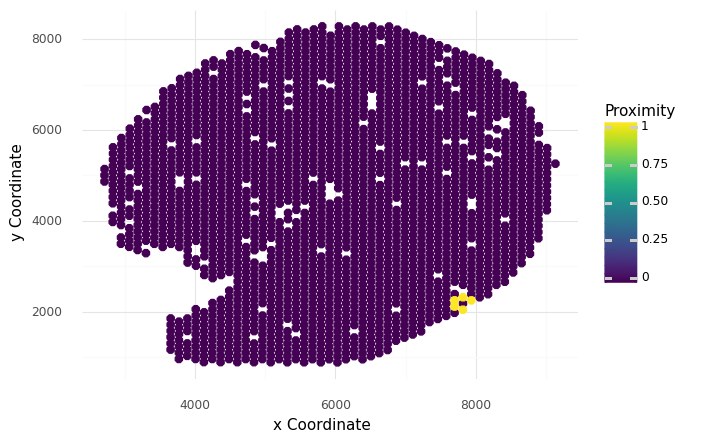

<ggplot: (8773810020542)>

In [ ]:
## TODO flip coordinates
li.pl.proximity_plot(adata, idx=1, spatial_key='spatial', proximity_key='spatial_connectivities')

In [ ]:
lrdata = lrdatas['f6wks']

In [ ]:
adata.uns['global_res'].sort_values('global_mean').tail(10)

,ligand,receptor,ligand_means,ligand_props,receptor_means,receptor_props,interaction,global_mean,global_sd
174,Tgm2,Itgb1,1.062551,0.847393,1.238781,0.862085,Tgm2&Itgb1,0.780537,0.245009
1113,Spp1,Itgav_Itgb1,5.205983,1.000000,0.987975,0.802844,Spp1&Itgav_Itgb1,0.805632,0.243830
2334,Timp1,Cd63,1.136890,0.811848,2.720397,0.994787,Timp1&Cd63,0.813973,0.246151
197,Tgm2,Sdc4,1.062551,0.847393,1.554439,0.931280,Tgm2&Sdc4,0.819289,0.205409
507,App,Aplp2,1.451256,0.928436,1.149898,0.877725,App&Aplp2,0.856303,0.182598
1157,Mfge8,Itgav,1.465557,0.923697,1.351061,0.903791,Mfge8&Itgav,0.861919,0.202380
506,H2-K1,Aplp2,1.565722,0.951659,1.149898,0.877725,H2-K1&Aplp2,0.864321,0.177198
154,Lgals1,Itgb1,2.485018,0.984360,1.238781,0.862085,Lgals1&Itgb1,0.864415,0.194182
1154,Calr,Itgav,2.238762,0.986256,1.351061,0.903791,Calr&Itgav,0.902828,0.170304
530,App,Rpsa,1.451256,0.928436,3.547689,0.999526,App&Rpsa,0.929566,0.127791


In [ ]:
# save results as modalities
local_lr  = li.fun.obsm_to_adata(adata, 'local_scores')
# local_pvals = li.fun.obsm_to_adata(adata, 'local_pvals')

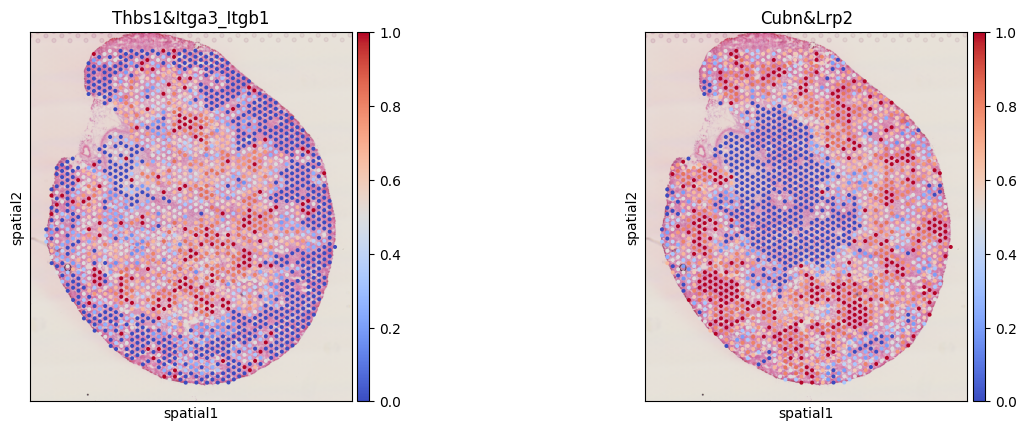

In [ ]:
sc.pl.spatial(local_lr, color=['Thbs1&Itga3_Itgb1', 'Cubn&Lrp2'], cmap='coolwarm')

## Run MOFAcell

In [ ]:
adata = sc.concat(adatas=adatas)
adata.obs['leiden'] = adata.obs['leiden'].replace({'5':'2'})

In [ ]:
mdata = li.multi.adata_to_views(adata,
                                groupby='leiden',
                                sample_key='sample',
                                obs_keys=None,
                                min_prop=0.05, # min nnz values (filter features)
                                min_smpls=3, # min samples per view (filter features)
                                min_cells=25, # min cells per view (filter samples)
                                min_counts=100, # min counts per view (filter samples)
                                mode='sum', # mode of aggregation
                                verbose=True,
                                skip_checks=True,
                                layer='counts'
                                )

In [ ]:
for mod in mdata.mod.keys():
    sc.pp.normalize_total(mdata.mod[mod], target_sum=1e4)
    sc.pp.log1p(mdata.mod[mod])
    
    sc.pp.highly_variable_genes(mdata.mod[mod], min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
model = mu.tl.mofa(mdata, 
                   use_obs='union',
                   convergence_mode='medium',
                   outfile="models/mofacell.hdf5",
                   n_factors=4,
                   use_var='highly_variable'
                   )

In [ ]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()

In [ ]:
model = mofa.mofa_model("models/mofacell.hdf5")
model

In [ ]:
mofa.plot_r2(model, x='View')

In [ ]:
model.close()

## Run MOFAtalk

In [ ]:
lrdata = sc.concat(lrdatas, join='outer', fill_value=0, uns_merge='unique')

In [ ]:
lrdata.obs['group'] = lrdata.obs['sample'].str.split('_').str[0]

In [ ]:
mdata = li.multi.adata_to_views(lrdata,
                                groupby='leiden',
                                sample_key='sample',
                                obs_keys=['group'],
                                min_prop=0.05, # min nnz values (filter features)
                                min_smpls=3, # min samples per view (filter features)
                                min_cells=25, # min cells per view (filter samples)
                                min_counts=0, # min counts per view (filter samples)
                                mode='mean', # mode of aggregation
                                verbose=True,
                                skip_checks=True
                                )

100%|██████████| 6/6 [00:00<00:00, 15.27it/s]


In [ ]:
mdata

MuData object with n_obs × n_vars = 5 × 3071
  obs:	'group'
  6 modalities
    4:	4 x 425
      layers:	'psbulk_props'
    1:	5 x 540
      layers:	'psbulk_props'
    3:	5 x 550
      layers:	'psbulk_props'
    2:	5 x 553
      layers:	'psbulk_props'
    0:	5 x 542
      layers:	'psbulk_props'
    5:	2 x 461
      layers:	'psbulk_props'

In [ ]:
model = mu.tl.mofa(mdata, 
                   use_obs='union',
                   convergence_mode='medium',
                   outfile="models/lrs.h5ad",
                   n_factors=5
                   )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='4' group='group1' with N=5 samples and D=425 features...
Loaded view='1' group='group1' with N=5 samples and D=540 features...
Loaded view='3' group='group1' with N=5 samples and D=550 features...
Loaded view='2' group='group1' with N=5 samples and D=553 features...
Loaded view='0' group='group1' with N=5 samples and D=542 features...
Loaded view='5' group='group1' 

In [ ]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()


,sample,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,group
0,f12hr,0.014546,-5.463077e-152,1.298755e-152,-9.092702e-152,7.930088e-148,f12hr
1,f2dps,-0.090113,-1.071617e-152,2.515300e-153,-1.765169e-152,1.559186e-148,f2dps
2,f4hr,0.140967,1.019243e-153,-2.449702e-154,1.722023e-153,-1.525852e-149,f4hr
3,f6wks,-0.087880,1.333120e-152,-3.124893e-153,2.197966e-152,-1.952778e-148,f6wks
4,fsham,0.024257,5.027314e-152,-1.196088e-152,8.367634e-152,-7.279249e-148,fsham


In [ ]:
model = mofa.mofa_model("models/lrs.h5ad")
model

MOFA+ model: lrs.h5ad
Samples (cells): 5
Features: 3071
Groups: group1 (5)
Views: 0 (542), 1 (540), 2 (553), 3 (550), 4 (425), 5 (461)
Factors: 5
Expectations: W, Z

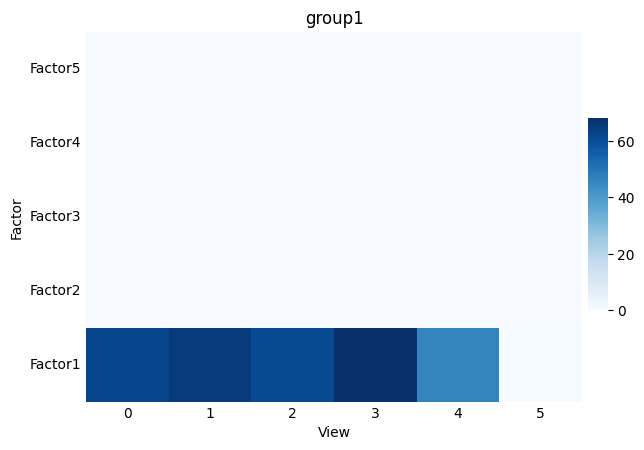

In [ ]:
mofa.plot_r2(model, x='View')

In [ ]:
factor1_loadings =  li.multi.get_variable_loadings(mdata, 0, view_separator=':') # get loadings for factor 1
## NOTE this should work, not only with 0...

In [ ]:
factor1_loadings.head(10)

,loadings,view,variable
1063,-3.884997,3,Calr&Lrp1
1386,-3.884250,3,Psap&Lrp1
1030,-3.868277,3,App&Lrp1
1019,-3.802556,3,Apoe&Lrp1
1251,-3.690028,3,Hsp90b1&Lrp1
1058,-3.653755,3,C1qb&Lrp1
1257,-3.450411,3,Hspg2&Lrp1
1424,-3.412170,3,Serping1&Lrp1
1171,-3.365470,3,Efemp2&Aqp1
1328,-3.232466,3,Lrpap1&Lrp1


## Run NMF

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
adata = adatas['fsham'].copy()

In [ ]:
del adata.uns['log1p']

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
adata = adata[:,adata.var['highly_variable']]

In [ ]:
adata = lrdatas[0].copy()

In [ ]:
# Create an instance of the NMF class
model = NMF(n_components=10, init='random')

# Fit the model to the data and obtain the factorized matrices
W = model.fit_transform(adata.X)
H = model.components_

In [ ]:
adata.obsm['NMF_W'] = pd.DataFrame(W, index=adata.obs.index)
adata.varm['NMF_H'] = H.T

In [ ]:
ad_nmf = li.fun.obsm_to_adata(adata, 'NMF_W') ## NOTE take index from adata.obs.index, not from the obsm matrix

In [ ]:
sc.pl.spatial(ad_nmf, color='3', cmap='coolwarm')

In [ ]:
lr_loadings = pd.DataFrame(adata.varm['NMF_H'], index=adata.var.index)

In [ ]:
lr_loadings.sort_values(3, ascending=False).head(10)

### NFM on the whole LR dataset

In [ ]:
lrdata

AnnData object with n_obs × n_vars = 8753 × 941
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'leiden', 'group'
    uns: 'spatial', 'spatial_neighbors'
    obsm: 'spatial', 'local_scores'

In [ ]:
# Create an instance of the NMF class
model = NMF(n_components=10, init='random')

# Fit the model to the data and obtain the factorized matrices
W = model.fit_transform(lrdata.X)
H = model.components_

In [ ]:
 ## NOTE take index from adata.obs.index, not from the obsm matrix
lrdata.obsm['NMF_W'] = pd.DataFrame(W, index=lrdata.obs.index)
lrdata.varm['NMF_H'] = H.T

In [ ]:
lrdatas

{'f6wks': AnnData object with n_obs × n_vars = 1514 × 841
     obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'leiden'
     uns: 'log1p', 'spatial', 'spatial_neighbors', 'global_res'
     obsm: 'spatial', 'local_scores'
     obsp: 'spatial_connectivities', 'spatial_distances',
 'f12hr': AnnData object with n_obs × n_vars = 1816 × 536
     obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'leiden'
     uns: 'log1p', 'spatial', 'spatial_neighbors', 'global_res'
     obsm: 'spatial', 'local_scores'
     obsp: 'spatial_connectivities', 'spatial_distances',
 'f4hr': AnnData object with n_obs × n_vars = 1847 × 209
     obs: 'in_tissue', 'array_row', 'array_col', 'sam

In [ ]:
lrdata

AnnData object with n_obs × n_vars = 8753 × 941
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'leiden', 'group'
    uns: 'spatial', 'spatial_neighbors'
    obsm: 'spatial', 'local_scores', 'NMF_W'
    varm: 'NMF_H'

In [ ]:
lrdata

AnnData object with n_obs × n_vars = 8753 × 941
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'leiden', 'group'
    uns: 'spatial', 'spatial_neighbors'
    obsm: 'spatial', 'local_scores', 'NMF_W'
    varm: 'NMF_H'

In [ ]:
lr = lrdatas[sample]


In [ ]:
temp = lrdata[lrdata.obs.index.isin(lr.obs.index)]
temp = temp[:,temp.var.index.isin(lr.var.index)]

In [ ]:
lr.obsm['NMF_W'] = temp.obsm['NMF_W']
lr.varm['NMF_H'] = temp.varm['NMF_H']

In [ ]:
nmfs = dict()
for sample in lrdatas:
    lr = lrdatas[sample]
    temp = lrdata[lrdata.obs.index.isin(lr.obs.index)]
    temp = temp[:,temp.var.index.isin(lr.var.index)]
    lr.obsm['NMF_W'] = temp.obsm['NMF_W']
    lr.varm['NMF_H'] = temp.varm['NMF_H']
    nmfs[sample] = lr

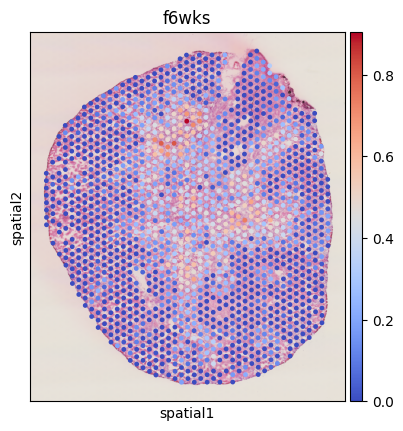

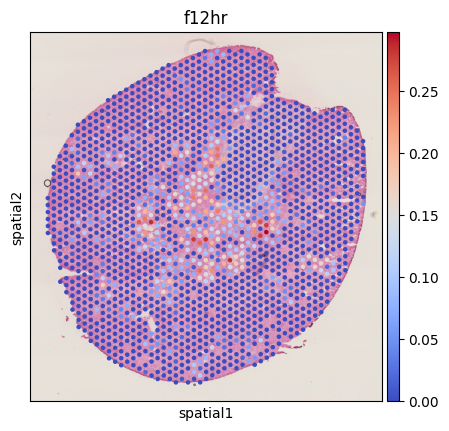

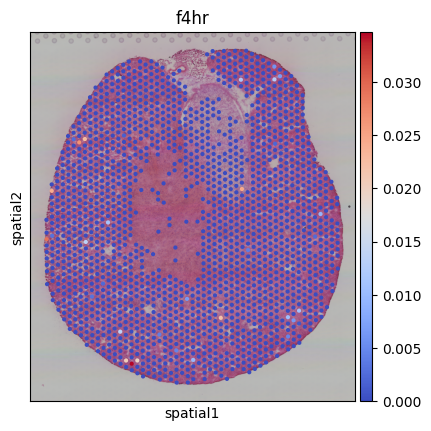

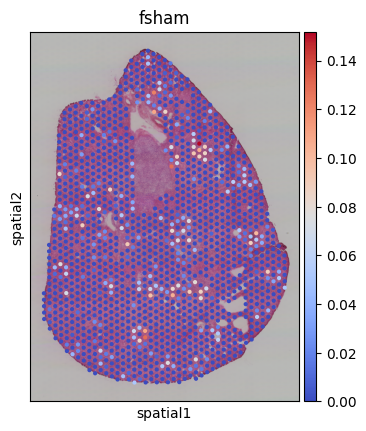

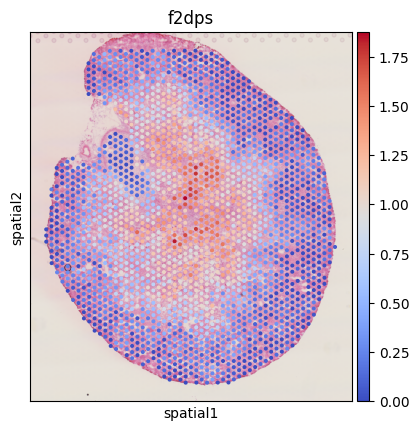

In [ ]:
for sample in nmfs.keys():
    ad_nmf = li.fun.obsm_to_adata(nmfs[sample], 'NMF_W')
    sc.pl.spatial(ad_nmf, color='8', cmap='coolwarm', title=sample)

In [ ]:
lr_loadings = pd.DataFrame(lrdata.varm['NMF_H'], index=lrdata.var.index)

In [115]:
lr_loadings.sort_values(8, ascending=False).head(20)

,0,1,2,3,4,5,6,7,8,9
interaction,,,,,,,,,,
Col1a1&Sdc1,0.416563,0.000000,0.000000,0.019844,0.107254,0.036175,0.000000,0.000000,0.478376,0.399934
Col6a2&Sdc1,0.321912,0.000000,0.000000,0.000000,0.096861,0.000000,0.000000,0.000000,0.451266,0.287224
Col6a1&Sdc1,0.294191,0.032721,0.000000,0.000000,0.106768,0.036794,0.000000,0.000000,0.446199,0.322238
Col1a1&Itga3_Itgb1,0.402094,0.049290,0.000000,0.103733,0.000000,0.133542,0.000000,0.000000,0.445785,0.228366
Col6a3&Sdc1,0.306314,0.044758,0.057328,0.006661,0.039142,0.053757,0.174442,0.000000,0.439879,0.352215
Col6a3&Itga9_Itgb1,0.000000,0.000000,0.129274,0.000000,0.000000,0.000000,0.000000,0.011710,0.438530,0.200973
Col6a2&Itga9_Itgb1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067633,0.435195,0.198745
Col1a1&Itga9_Itgb1,0.006351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068806,0.433724,0.205264
Col1a2&Itga9_Itgb1,0.000000,0.000000,0.168629,0.016634,0.000000,0.000000,0.000000,0.006598,0.433669,0.205054
